In [1]:
from ex2.mdp import RoboMDP
from ex2.misc import plot_v_pi
import numpy as np
import matplotlib.pyplot as plt

### MDP

The MDP class for the cleaning robot is already implemented and doesn't need to be changed. Instead, we define an environment building upon the MDP which only provides a step function that takes an action and returns the next state, a reward function and a flag whether you ended up in a terminal state.

In [2]:
class RoboMDPEnv(RoboMDP):
    def __init__(self, discount: float, stochastic: bool):
        self._currrent_state = None
        self._time_step = 0
        self._time_limit = 100
        super().__init__(discount, stochastic)

    def reset(self):
        obj = 'O'
        while obj in ('O', 'C'):
            s_init = np.random.randint(0, 100)
            r, c = self.to_rc(s_init)
            obj = self.grid_world['map'][int(r)][int(c)]
        self._currrent_state = s_init
        self._time_step = 0
        return s_init

    def step(self, action):
        s_dash, tp = zip(*self.stp[self._currrent_state, action])

        next_state = int(np.random.choice(s_dash, size=1, p=tp))

        reward = self.rewards[next_state]

        r_dash, c_dash = self.to_rc(next_state)
        obj = self.grid_world['map'][int(r_dash)][int(c_dash)]
        done = obj in ('O', 'C') or self._time_step == self._time_limit - 1

        self._currrent_state = next_state
        self._time_step += 1

        return next_state, reward, done, {}


## Tabular Q-Learning

For exercise 2, you'll implement tabular Q-learning, which has the following pseudocode:

---
Initialize $Q_{(0)}(s, a)=0$, for all $s$ and $a$, get initial state $s$

For $i=0, 1, 2, \dots$
- sample action $a$ using exploration policy, execute it and get next state $s'$
- if $s'$ is terminal:
- &nbsp;&nbsp;&nbsp;&nbsp; $\delta = r(s, a) - Q(s,a)$
- &nbsp;&nbsp;&nbsp;&nbsp; sample new inital state
- else:
- &nbsp;&nbsp;&nbsp;&nbsp; $\delta = r(s, a) + \gamma \max_{a'} Q(s', a') - Q(s,a)$
- $Q_{(i+1)}(s, a) = Q_i(s, a) + \alpha \delta$
- $s \leftarrow s'$


---

The greedy policy is given by $\pi_{(i)}(s) = \underset{a}{\arg \max} Q_i(s, a)$


#### Hints
- Use the functions $\texttt{to_s}$ and $\texttt{to_rc}$ provided by the MDP class to convert between linear states
 $s \in [0, |\mathcal{S}|]$ and row/column format, i.e. $\texttt{mdp.to_rc(0)}$ returns $(0, 0)$, while
 $\texttt{mdp.to_s(0, 0)}$ returns $0$
- Following numpy functions may be useful: $\texttt{np.sum}$, $\texttt{np.max}$, $\texttt{np.argmax}$, $\texttt{np.where}$, $\texttt{np.minimum}$, $\texttt{np.random.randint}$, $\texttt{np.random.random}$, $\texttt{np.random.choice}$
- If you cannot achieve an annealing epsilon strategy, implement a constant epsilon greedy strategy (this might result in worse behavior)


## 2 a) Exploration Strategy

In [3]:
def sample_action(state, q, t):
    r, c = env.to_rc(state)
    epsilon = 1 - np.maximum(t / 100000, 0.05)
    if np.random.random() < epsilon:
        return np.random.randint(0, 5)
    else:
        a_star = np.random.choice(np.where(q[r, c, :] == np.max(q[r, c, :]))[0])
        return a_star

## 2 b) TD-Error

In [4]:
def get_td_error(state, action, reward, next_state, done, q):
    r, c = env.to_rc(state)
    r_dash, c_dash = env.to_rc(s_dash)
    if done:
        delta = reward - q[r, c, a]
    else:
        delta = reward + gamma * np.max(q[r_dash, c_dash, :]) - q[r, c, a]
    return delta

## 2 c) Update Q-Table

In [5]:
def update_q_table(state, action, q, delta):
    r, c = env.to_rc(state)
    q[r, c, a] = q[r, c, a] + alpha * delta
    return q

## Setup
Run the next cell before each run of the Q-learning loop

In [6]:
alpha = 0.3 # learning rate
gamma = 0.95 # discount factor
env = RoboMDPEnv(discount=gamma, stochastic=False)

# initial Q-function
q = np.zeros(shape=(RoboMDPEnv.world_dim + (RoboMDPEnv.n_actions, )))

# initial state
s = env.reset()

## Training loop

In [7]:
# run the Q-learning loop for 100000 steps
for i in range(100000):

    # get action and execute it
    a = sample_action(s, q, i)
    s_dash, reward, done, info = env.step(a)

    # compute TD-error
    delta = get_td_error(s, a, reward, s_dash, done, q)
    
    # update Q-table
    q = update_q_table(s, a, q, delta)
    
    # set s for the next iteration
    if done:
        s = env.reset()
    else:
        s = s_dash
        
    # anneal learning rate
    alpha *= 0.99995

print("Policy: \n", np.argmax(q, axis=2))

Policy: 
 [[1 1 1 0 3 3 3 3 0 3]
 [2 0 1 0 3 0 3 0 4 0]
 [2 0 1 4 0 0 0 4 0 1]
 [1 1 2 0 0 0 0 0 1 2]
 [0 0 1 0 1 0 0 0 0 2]
 [0 0 0 0 1 0 0 0 0 2]
 [1 1 1 1 1 1 1 1 1 2]
 [1 2 2 2 2 0 1 1 2 2]
 [0 2 0 0 0 0 2 2 2 2]
 [0 3 3 3 3 0 2 0 0 0]]


## 2 d) Plot of the learned value function and policy

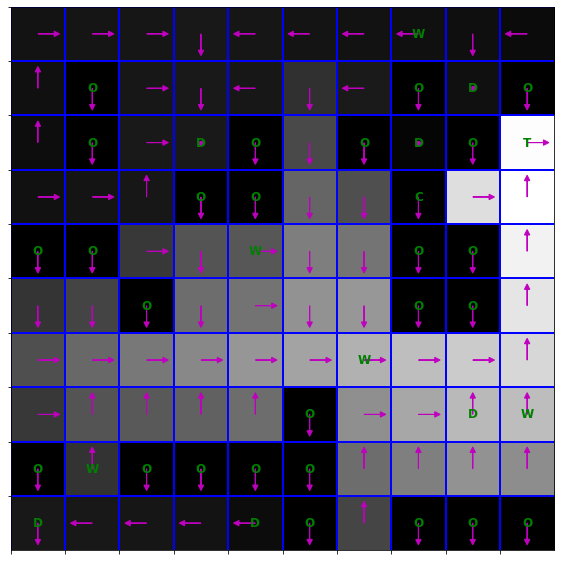

In [8]:
pi = np.argmax(q, axis=2)
v = np.max(q, axis=2)
plot_v_pi(v, pi, env)